In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Add the Temporal-SCL directory to the sys.path.
sys.path.append('../model')
sys.path.append('../model/utils')
sys.path.append('../')

from model.run_training_helpers import run_temporal_scl
from model.run_model import read_args_from_json
from model.utils.gerenate_data import get_data_synethtic, plot_hypersphere, get_data_synethtic_downstream_test


## Generate Synthetic Data

In [2]:
cluster_locations = [0, 40, 75, 105, 140, 180, -140, -105, -75, -40]
# Set Random Seed
random_seed = 42

data = get_data_synethtic(data_cluster_locations=cluster_locations, num_data_points_per_cluster=200, sigma=0.05, dimension=2, seed=random_seed)

data_x, data_y, data_path = data['data_x'], data['data_y'], data['data_path']

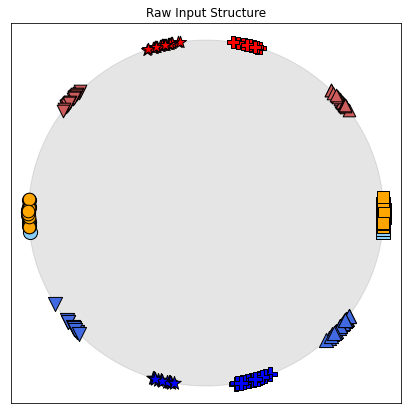

In [3]:
proportion_visualized = 0.1

plot_hypersphere(data_x, data_y, proportion_visualized=proportion_visualized, title_txt="Raw Input Structure", data_pp=data_path, marker_size=200, fig_size=(7, 7))

## Train Temporal-SCL

In [17]:
# Config file for the model hyperparameters
args_path = '../model/args_synthetic.json'

args = read_args_from_json(args_path)

In [18]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

pretraining_dict, training_dict = run_temporal_scl(embedding_size=args.embedding_size, hidden_sizes_scl=args.hidden_sizes_scl, hidden_sizes_clf=args.hidden_sizes_clf,
                                                   hidden_size_temporal=args.hidden_size_temporal, num_temporal_layers=args.num_temporal_layers,
                                                   activation_scl=args.activation_scl, activation_clf=args.activation_clf, 
                                                   is_hyper_sphere=args.is_hyper_sphere, is_binary_classification=args.is_binary_classification,
                                                   train_batch_size=args.train_batch_size, valid_batch_size=args.valid_batch_size, test_batch_size=args.test_batch_size,
                                                   num_epochs_scl=args.num_epochs_scl, num_epochs_clf=args.num_epochs_clf, num_epochs_temporal=args.num_epochs_temporal,
                                                   num_epochs_scl_pretrain=args.num_epochs_scl_pretrain, num_epochs_clf_pretrain=args.num_epochs_clf_pretrain,
                                                   lr_scl=args.lr_scl, lr_clf=args.lr_clf, lr_temporal=args.lr_temporal,
                                                   temperature_scl=args.temperature_scl,
                                                   model_clf_str=args.model_clf_str, model_temporal_str=args.model_temporal_str,
                                                   criterion_temporal=args.criterion_temporal,
                                                   do_nn_pairing=args.do_nn_pairing, nn_pairing_k=args.nn_pairing_k,
                                                   alpha_temporal=args.alpha_temporal, temporal_l2_reg_coeff=args.temporal_l2_reg_coeff,
                                                   data_x=data_x, data_y=data_y, use_external_class=args.use_external_class, predict_raw_temporal=args.predict_raw_temporal,
                                                   valid_size=args.valid_size, test_size=args.test_size, seed=args.seed, shuffle_data=args.shuffle_data,
                                                   use_nn_clf=args.use_nn_clf, knn_clf=args.knn_clf, nn_metric=args.nn_metric, approximate_nn=args.approximate_nn,
                                                   return_embedding=args.return_embedding, saved_train_loader=args.nn_train_loader_is_saved, 
                                                   nn_train_loader_path=args.nn_train_loader_path,
                                                   do_save_train_loader=args.do_save_nn_train_loader, use_gpu=args.use_gpu,
                                                   tensorboar_string=args.tensorboard_string, experiment_name=args.experiment_name, verbose=args.verbose)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 17.67it/s]


Trying to load saved train loader from: ../results/Synthetic/Synthetic_train_1NN_loader.pkl
Successfully loaded saved train loader.


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Temporal-SCL - Training: AUROC:0.9441, AUPRC:0.9486
Temporal-SCL - Validation: AUROC:0.9445, AUPRC:0.9490
Temporal-SCL - Test: AUROC:0.9468, AUPRC:0.9509


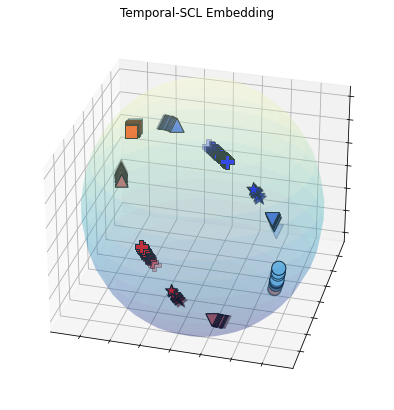

In [19]:
with torch.no_grad():
    training_dict['models']['scl'].eval().eval()
    data_z = training_dict['models']['scl'].eval()(torch.tensor(np.vstack(data_x)).to('cuda' if torch.cuda.is_available() else 'cpu').float()).cpu().numpy()

plot_hypersphere(data_z, data_y, proportion_visualized=proportion_visualized, title_txt=f"Temporal-SCL Embedding", data_pp=data_path, 
                marker_size=200, fig_size=(7, 7),
                elev=30, azim=300-15)

## Downstream Task: Predicting Cluster Location

In [14]:
cluster_locations = [0, 40, 75, 105, 140, 180, -140, -105, -75, -40]
# Set Random Seed
random_seed = 42

data_downstream_test = get_data_synethtic_downstream_test(data_cluster_locations=cluster_locations, num_data_points_per_cluster=100, sigma=0.05, dimension=2, seed=random_seed)

data_x_dst = data_downstream_test['data_x']
data_y_dst = data_downstream_test['data_y']
data_path_dst = data_downstream_test['data_path']
data_cluster_dst = data_downstream_test['data_cluster']

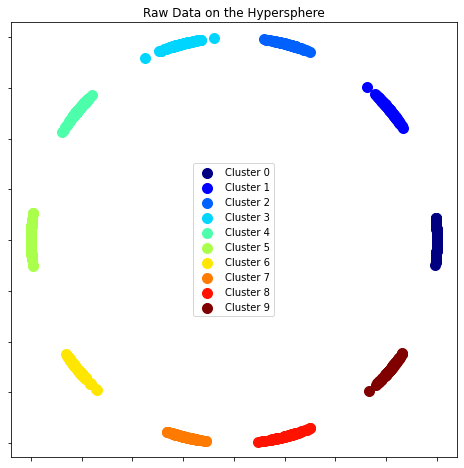

In [15]:
# Normalize the cluster ids for the colormap
norm = Normalize(vmin=np.min(np.concatenate(data_cluster_dst)), vmax=np.max(np.concatenate(data_cluster_dst)))
cmap = cm.jet

# Create the plot
plt.figure(figsize=(8, 8))

# Plot each cluster with a different color and label
for cluster_id in np.unique(np.concatenate(data_cluster_dst)):
    indices = (np.concatenate(data_cluster_dst) == cluster_id).flatten()
    plt.scatter(np.vstack(data_x_dst)[indices, 0], np.vstack(data_x_dst)[indices, 1], 
                color=cmap(norm(cluster_id)), label=f'Cluster {cluster_id}', s=100)

# Turn off x, y, and z tick labels
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

plt.legend()
plt.axis('equal')
plt.title("Raw Data on the Hypersphere")
plt.show()


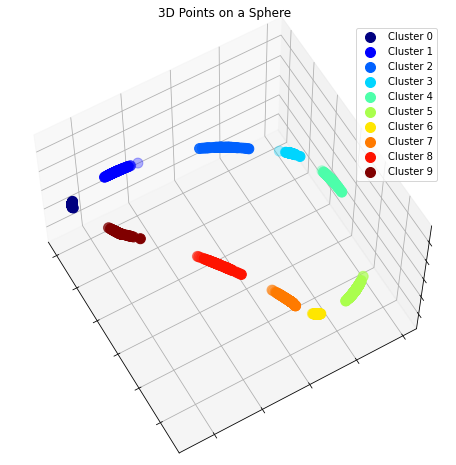

In [16]:
with torch.no_grad():
    training_dict['models']['scl'].eval().eval()
    data_z_dst = training_dict['models']['scl'].eval()(torch.tensor(np.vstack(data_x_dst)).to('cuda' if torch.cuda.is_available() else 'cpu').float()).cpu().numpy()

# Plot the Embedding Space
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a different color and label
for cluster_id in np.unique(np.concatenate(data_cluster_dst)):
    indices = (np.concatenate(data_cluster_dst) == cluster_id).flatten()
    plt.scatter(data_z_dst[indices, 0], data_z_dst[indices, 1], 
                color=cmap(norm(cluster_id)), label=f'Cluster {cluster_id}', s=100)

# Customize the plot as needed
plt.legend()
ax.set_title("3D Points on a Sphere")

# Turn off x, y, and z tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.view_init(300, 30)

plt.show()

### Downstream Task Evaluation

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, silhouette_score


def get_downstream_task_prediction(X, y):

    num_classes = len(np.unique(np.concatenate(data_cluster_dst).flatten()))
    # Split the data into training (70%) and testing (30%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train a logistic regression model
    model = LogisticRegression(max_iter=100, multi_class='auto', solver='lbfgs')
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Probability estimates for each class, necessary for AUROC and AUPRC
    y_prob = model.predict_proba(X_test)

    # Calculate AUROC for each class
    auroc = roc_auc_score(np.eye(num_classes)[y_test], y_prob, average='macro')

    # Calculate AUPRC for each class
    auprc = average_precision_score(np.eye(num_classes)[y_test], y_prob, average='macro')

    # Calculate Silhouette Index
    si_score = silhouette_score(X_test, y_test, metric='cosine')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC: {auroc:.2f}")
    print(f"AUPRC: {auprc:.2f}")
    print(f"Silhouette Index: {si_score:.2f}")

get_downstream_task_prediction(X=data_z_dst, y=np.concatenate(data_cluster_dst).flatten())

Accuracy: 1.0000
AUROC: 1.00
AUPRC: 1.00
Silhouette Index: 0.98
